# Parte 1 - Preprocesado de los datos

### Importación de las librerías

In [1]:
import tensorflow as tf
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num of GPUs available:  13


In [2]:
#!pip install matplotlib
#!pip install -U scikit-learn scipy matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Importar el dataset

Cuidado con el tiempo

In [4]:
dataset = pd.read_csv('C:\\Users\\rosag\\Documents\\TFM_OCEANOGR\\3_ CODIGO_estudio\\datos\\current_near_canarias_cleaned.csv',parse_dates=["time"], index_col='time')
dataset.head

<bound method NDFrame.head of                         depth  latitude  longitude        vo        uo
time                                                                  
2020-11-16 00:00:00  0.494025      20.0      -20.0 -0.005561 -0.109776
2020-12-16 12:00:00  0.494025      20.0      -20.0  0.051936 -0.047401
2021-01-16 12:00:00  0.494025      20.0      -20.0  0.071750  0.055303
2021-02-15 00:00:00  0.494025      20.0      -20.0 -0.008981 -0.000131
2021-03-16 12:00:00  0.494025      20.0      -20.0  0.003899 -0.088403
...                       ...       ...        ...       ...       ...
2022-10-16 12:00:00  0.494025      30.0      -10.0 -0.073915 -0.051269
2022-11-16 00:00:00  0.494025      30.0      -10.0 -0.014871  0.024489
2022-12-16 12:00:00  0.494025      30.0      -10.0  0.015167 -0.000492
2023-01-16 12:00:00  0.494025      30.0      -10.0 -0.135187 -0.057884
2023-02-15 00:00:00  0.494025      30.0      -10.0 -0.061132  0.007191

[227304 rows x 5 columns]>

In [5]:
#defino las columnas
dataset.columns=['depth','latitude','longitude','vo','uo']  #primer valor predicho uo
dataset.index.name='date'
dataset.head

<bound method NDFrame.head of                         depth  latitude  longitude        vo        uo
date                                                                  
2020-11-16 00:00:00  0.494025      20.0      -20.0 -0.005561 -0.109776
2020-12-16 12:00:00  0.494025      20.0      -20.0  0.051936 -0.047401
2021-01-16 12:00:00  0.494025      20.0      -20.0  0.071750  0.055303
2021-02-15 00:00:00  0.494025      20.0      -20.0 -0.008981 -0.000131
2021-03-16 12:00:00  0.494025      20.0      -20.0  0.003899 -0.088403
...                       ...       ...        ...       ...       ...
2022-10-16 12:00:00  0.494025      30.0      -10.0 -0.073915 -0.051269
2022-11-16 00:00:00  0.494025      30.0      -10.0 -0.014871  0.024489
2022-12-16 12:00:00  0.494025      30.0      -10.0  0.015167 -0.000492
2023-01-16 12:00:00  0.494025      30.0      -10.0 -0.135187 -0.057884
2023-02-15 00:00:00  0.494025      30.0      -10.0 -0.061132  0.007191

[227304 rows x 5 columns]>

### NaN

In [16]:
# mark all NA values with 0
dataset.fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('corrientes2.csv')  #nuevo csv

                        depth  latitude  longitude        vo        uo
date                                                                  
2022-07-16 12:00:00  0.494025      20.0 -19.916656  0.012685 -0.136682
2022-08-16 12:00:00  0.494025      20.0 -19.916656 -0.031826 -0.167085
2022-09-16 00:00:00  0.494025      20.0 -19.916656  0.029982 -0.193211
2022-10-16 12:00:00  0.494025      20.0 -19.916656 -0.108676 -0.239323
2022-11-16 00:00:00  0.494025      20.0 -19.916656  0.010598 -0.145192


The code below loads the new “corrientes.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

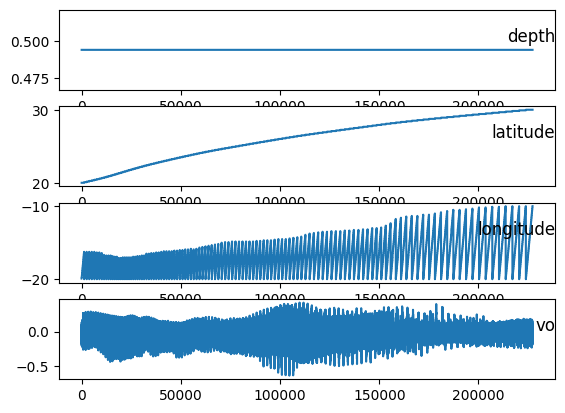

In [17]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('corrientes2.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

### Configuración ventana deslizante

Enmarcaremos el problema de aprendizaje supervisado como la predicción de u en la hora actual (t) dada la medición de la u y las condiciones climáticas en el paso de tiempo anterior.

In [18]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [19]:
#load dataset
dataset=read_csv('corrientes2.csv', header=0, index_col=0)
values=dataset.values

#### Datos categóricos

In [20]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

#### Ensure all data is float

In [21]:
values = values.astype('float32')

#### Normalización

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var1(t)  var2(t)  \
1        0.0        0.0   0.008334   0.614063   0.431973      0.0      0.0   
2        0.0        0.0   0.008334   0.572433   0.401147      0.0      0.0   
3        0.0        0.0   0.008334   0.630241   0.374658      0.0      0.0   
4        0.0        0.0   0.008334   0.500555   0.327905      0.0      0.0   
5        0.0        0.0   0.008334   0.612111   0.423345      0.0      0.0   

    var3(t)   var4(t)   var5(t)  
1  0.008334  0.572433  0.401147  
2  0.008334  0.630241  0.374658  
3  0.008334  0.500555  0.327905  
4  0.008334  0.612111  0.423345  
5  0.008334  0.630722  0.498067  


### Separar conjunto train y test

In [23]:
from sklearn.model_selection import train_test_split
values = reframed.values
X=values[:, :-1]
y=values[:,-1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape
(181804, 1, 9) (181804,) (45451, 1, 9) (45451,)


In [25]:
print("train_y shape", train_y.shape)
print('test_X shape', test_X.shape)
print('test_y shape', test_y.shape)

train_y shape (181804,)
test_X shape (45451, 1, 9)
test_y shape (45451,)


### Configuración red

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


### Entrenamiento red

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/500
2526/2526 - 8s - loss: 0.0584 - val_loss: 0.0543
Epoch 2/500
2526/2526 - 5s - loss: 0.0543 - val_loss: 0.0537
Epoch 3/500
2526/2526 - 5s - loss: 0.0539 - val_loss: 0.0534
Epoch 4/500
2526/2526 - 5s - loss: 0.0536 - val_loss: 0.0531
Epoch 5/500
2526/2526 - 5s - loss: 0.0533 - val_loss: 0.0531
Epoch 6/500
2526/2526 - 5s - loss: 0.0531 - val_loss: 0.0533
Epoch 7/500
2526/2526 - 5s - loss: 0.0530 - val_loss: 0.0529
Epoch 8/500
2526/2526 - 5s - loss: 0.0529 - val_loss: 0.0530
Epoch 9/500
2526/2526 - 5s - loss: 0.0528 - val_loss: 0.0527
Epoch 10/500
2526/2526 - 5s - loss: 0.0528 - val_loss: 0.0526
Epoch 11/500
2526/2526 - 5s - loss: 0.0527 - val_loss: 0.0530
Epoch 12/500
2526/2526 - 5s - loss: 0.0527 - val_loss: 0.0531
Epoch 13/500
2526/2526 - 5s - loss: 0.0526 - val_loss: 0.0528
Epoch 14/500
2526/2526 - 5s - loss: 0.0526 - val_loss: 0.0528
Epoch 15/500
2526/2526 - 5s - loss: 0.0525 - val_loss: 0.0527
Epoch 16/500
2526/2526 - 5s - loss: 0.0524 - val_loss: 0.0526
Epoch 17/500
2526

### Evaluación del modelo

In [ ]:
from keras.layers import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [ ]:
# calculate RMSE
from numpy import sqrt 
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_yhat[33]

In [ ]:
inv_y[33]

## Multivariate Multi-Step LSTM Models
Es posible mezclar y combinar los diferentes tipos de modelos LSTM presentados hasta ahora para los diferentes problemas. Esto también se aplica a los problemas de pronóstico de series de tiempo que involucran pronósticos multivariados y de múltiples pasos, pero puede ser un poco más desafiante.

En esta sección, proporcionaremos ejemplos breves de preparación y modelado de datos para pronósticos de series de tiempo de varios pasos y variables múltiples como una plantilla para facilitar este desafío, específicamente:

* Salida de varios pasos de entrada múltiple.
* Entrada paralela múltiple y salida de varios pasos.
Quizás el mayor escollo esté en la preparación de los datos, por lo que es ahí donde centraremos nuestra atención.

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### Multiple Input Multi-Step Output

Existen esos problemas de pronóstico de series de tiempo multivariadas donde la serie de salida está separada pero depende de la serie de tiempo de entrada, y se requieren múltiples pasos de tiempo para la serie de salida. Podemos usar tres pasos de tiempo anteriores de cada una de las dos series de tiempo de entrada para predecir dos pasos de tiempo de la serie de tiempo de salida.

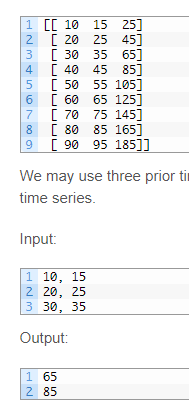

In [ ]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

### Multiple Parallel Input and Multi-Step Output

Un problema con series de tiempo paralelas puede requerir la predicción de múltiples pasos de tiempo de cada serie de tiempo.

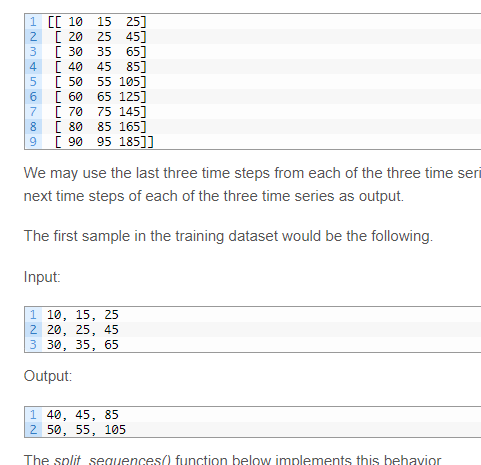

In [ ]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)